In [1]:
%matplotlib notebook

import numpy as np

import matplotlib.pyplot as plt

from mpmath import polylog

import scipy 
from scipy import sparse
from scipy.sparse import linalg as spla


In [2]:
def exact_g(V, Vd, n):

    if hasattr(V, '__iter__'):
        PLA = np.array([float(polylog(2,-np.exp(Vd+x*(1+2/n)))) for x in V])
        PLB = np.array([float(polylog(2,-np.exp(-Vd+x*(1+2/n)))) for x in V])
    else:
        PLA = float(polylog(2,-np.exp(Vd+V*(1+2/n))))
        PLB = float(polylog(2,-np.exp(-Vd+V*(1+2/n))))
        
    g = V*(2*Vd+V)
    g += (2*n/(n+2))*PLA
    g -= (2*n/(n+2))*PLB
    
    return g

def approx_g_1st(V, Vd, n):

    g = V**2 - 4*Vd*(n/(n+2))*np.log(2*np.cosh((V/2)*(n+2)/n))
    
    return g

def g_1st(V, Vd, n):

    g = - 4*Vd*(n/(n+2))*np.log(2*np.cosh((V/2)*(n+2)/n))
    
    return g


def approx_g_3rd(V, Vd, n):

    g = V**2 - 4*Vd*(n/(n+2))*np.log(2*np.cosh((V/2)*(n+2)/n))
    g -= (n/(6*(2+n)))*(Vd**3)/np.cosh((2+n)*V/(2*n))
    
    return g

<IPython.core.display.Javascript object>


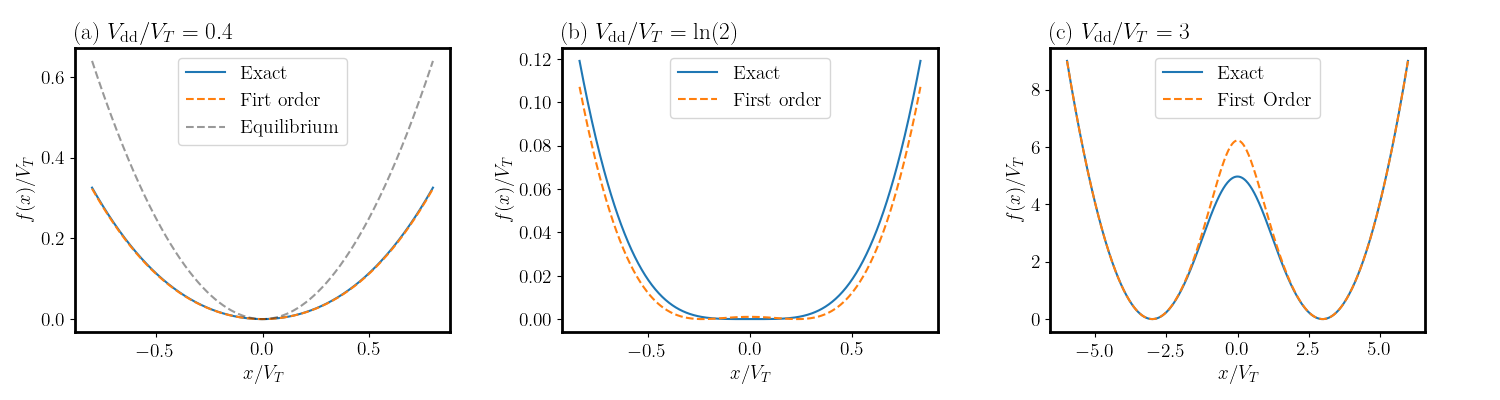

Text(0.0, 1.0, '(c) $V_\\mathrm{dd}/V_T = 3$')

In [17]:
# effective potential 
#Direct input 
plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
#Options
params = {'text.usetex' : True,
          'font.size' : 14,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params) 

fig, axs = plt.subplots(1,3, figsize=(15,4), dpi=100)
plt.gcf().subplots_adjust(left=.05, right=.95, bottom=.17, wspace=.3)
for ax in axs:
    plt.setp(ax.spines.values(), linewidth=2)
    

n = 1
vd = .4

V = np.linspace(-2*vd,2*vd,500)
EQ = np.array([exact_g(v, 0, n) for v in V])
EG = np.array([exact_g(v, vd, n) for v in V])
AG1 = np.array([approx_g_1st(v, vd, n) for v in V])
EQ = EQ-np.min(EQ)
EG = EG-np.min(EG)
AG1 = AG1-np.min(AG1)

l1 = axs[0].plot(V, EG, color='C0', label=r'Exact')
l2 = axs[0].plot(V, AG1, '--', color='C1', label='Firt order')
l3 = axs[0].plot(V, EQ, '--', color='black', alpha=.4, label='Equilibrium')

axs[0].set_xlabel(r'$x/V_T$')
axs[0].set_ylabel(r'$f(x)/V_T$')
axs[0].legend()
axs[0].set_title('(a) $V_\mathrm{dd}/V_T = 0.4$', loc='left')


n = 1
vd = np.log(2)

V = np.linspace(-1.2*vd,1.2*vd,500)
EG = np.array([exact_g(v, vd, n) for v in V])
AG1 = np.array([approx_g_1st(v, vd, n) for v in V])
EG = EG-np.min(EG)
AG1 = AG1-np.min(AG1)

axs[1].plot(V, EG, color='C0', label='Exact')
axs[1].plot(V, AG1, '--', color='C1', label='First order')

axs[1].set_xlabel(r'$x/V_T$')
axs[1].set_ylabel(r'$f(x)/V_T$')
axs[1].legend()
axs[1].set_title('(b) $V_\mathrm{dd}/V_T = \ln(2)$', loc='left')



n = 1
vd = 3

V = np.linspace(-2*vd,2*vd,500)
#EQ = np.array([exact_g(v, 0, n) for v in V])
EG = np.array([exact_g(v, vd, n) for v in V])
AG1 = np.array([approx_g_1st(v, vd, n) for v in V])
#EQ = EQ-np.min(EQ)
EG = EG-np.min(EG)
AG1 = AG1-np.min(AG1)

axs[2].plot(V, EG, color='C0', label='Exact')
axs[2].plot(V, AG1, '--', color='C1', label='First Order')

axs[2].set_xlabel(r'$x/V_T$')
axs[2].set_ylabel(r'$f(x)/V_T$')
axs[2].legend()
axs[2].set_title('(c) $V_\mathrm{dd}/V_T = 3$', loc='left')


In [5]:
from scipy.integrate import ode


def drift(t, V, vd):
    
    wp = lambda v1,v2: np.exp(vd-v2)
    wm = lambda v1,v2: wp(v1,v2)*np.exp(-vd+v1)
    
    I = lambda v1,v2: wp(v1,v2) - wm(v1,v2)
    
    u1 = I(V[0],V[1]) - I(-V[0],-V[1])
    u2 = I(V[1],V[0]) - I(-V[1],-V[0])
    
    return np.array([u1, u2])
    

def work_rate(V, vd):
    
    wp = lambda v1,v2: np.exp(vd-v2)
    wm = lambda v1,v2: wp(v1,v2)*np.exp(-vd+v1)
    
    I = lambda v1,v2: wp(v1,v2) - wm(v1,v2)
    
    W = vd*(I(V[0],V[1]) + I(-V[0],-V[1]) + I(V[1],V[0]) + I(-V[1],-V[0]))
    
    return W

# def heat_rate(V, vd):
    
#     wp = lambda v1,v2: np.exp(vd-v2)
#     wm = lambda v1,v2: wp(v1,v2)*np.exp(-vd+v1)
    
#     I = lambda v1,v2: wp(v1,v2) - wm(v1,v2)
    
#     Q = (vd-V[0])*I(V[0],V[1]) 
#     Q += (V[0]+vd)*I(-V[0],-V[1]) 
#     Q += (vd-V[1])*I(V[1],V[0])
#     Q += (V[1]+vd)*I(-V[1],-V[0])
    
#     return Q

def heat_rate(V, vd):
    
    wp = lambda v1,v2: np.exp(vd-v2)
    wm = lambda v1,v2: wp(v1,v2)*np.exp(-vd+v1)  
    
    Q = (wp(V[0],V[1]) - wm(V[0],V[1]))*np.log(wp(V[0],V[1])/wm(V[0],V[1])) 
    Q += (wp(-V[0],-V[1]) - wm(-V[0],-V[1]))*np.log(wp(-V[0],-V[1])/wm(-V[0],-V[1]))
    Q += (wp(V[1],V[0]) - wm(V[1],V[0]))*np.log(wp(V[1],V[0])/wm(V[1],V[0]))
    Q += (wp(-V[1],-V[0]) - wm(-V[1],-V[0]))*np.log(wp(-V[1],-V[0])/wm(-V[1],-V[0]))
    
    return Q


def linear_work_rate(V, vd):
    
    wp = lambda v1,v2: np.exp(-v2) # equilibrium rates
    wm = lambda v1,v2: wp(v1,v2)*np.exp(v1)
    
    I = lambda v1,v2: wp(v1,v2) - wm(v1,v2)
    
    W = vd*(I(V[0],V[1]) + I(-V[0],-V[1]) + I(V[1],V[0]) + I(-V[1],-V[0]))
    
    return W


def energy(V):
    
    return .5*(V[0]**2 + V[1]**2)


def cg_heat_rate(V, vd):
    
    wp = lambda v1,v2: np.exp(vd-v2)
    wm = lambda v1,v2: wp(v1,v2)*np.exp(-vd+v1)  
    
    WP = lambda v1, v2: wp(v1,v2) + wm(-v1,-v2)
    WM = lambda v1, v2: wm(v1,v2) + wp(-v1,-v2)
    
    Q = (WP(V[0],V[1]) - WM(V[0],V[1]))*np.log(WP(V[0],V[1])/WM(V[0],V[1])) 
    Q += (WP(V[1],V[0]) - WM(V[1],V[0]))*np.log(WP(V[1],V[0])/WM(V[1],V[0]))
    
    return Q


In [6]:
r = ode(drift)

vd = 1.3
v0 = [2.35,0.45]
#v0 = [4.8,-4.8]

r.set_initial_value(v0, 0).set_f_params(vd)

V = [v0]
T = [0]
dt = 1e-5

while r.successful() and r.t < 20e-1:
    T.append(r.t+dt)
    V.append(r.integrate(r.t+dt))

W = np.array([work_rate(v, vd) for v in V])
Q = np.array([heat_rate(v, vd) for v in V])
E = np.array([energy(v)-energy(v0) for v in V])

<IPython.core.display.Javascript object>


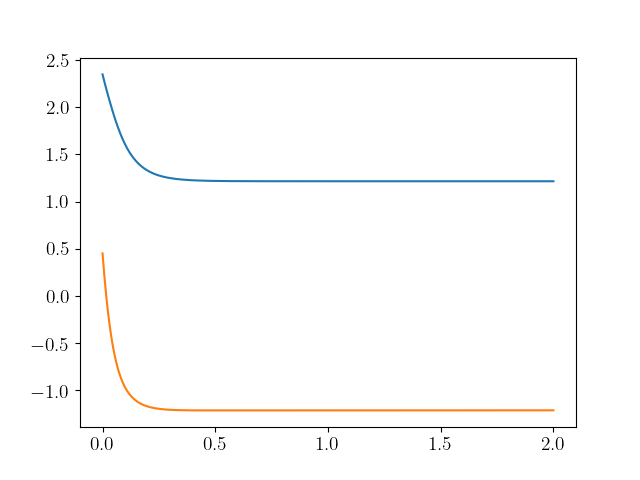

<IPython.core.display.Javascript object>


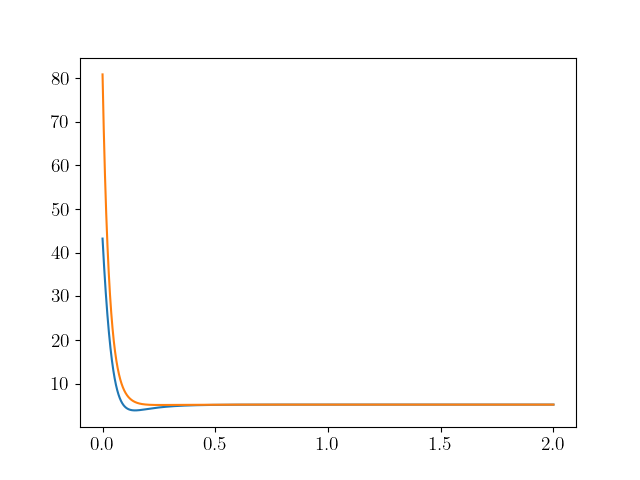

<IPython.core.display.Javascript object>


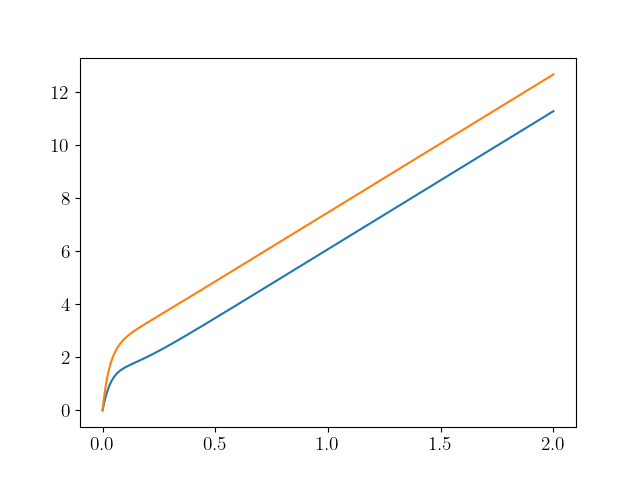

<IPython.core.display.Javascript object>


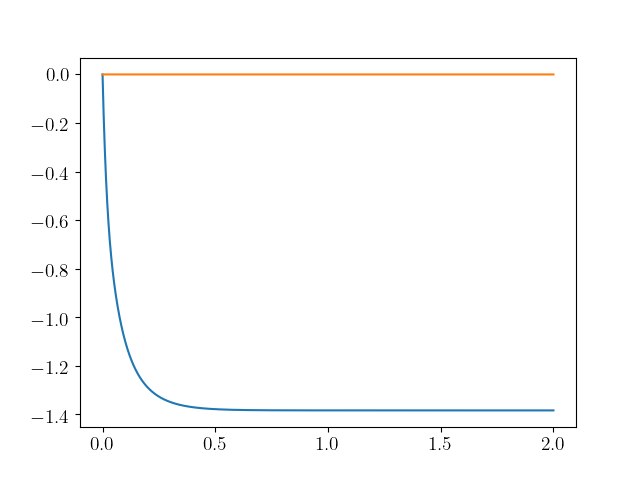

In [7]:
plt.figure()
plt.plot(T, [v[0] for v in V])
plt.plot(T, [v[1] for v in V])

plt.figure()
plt.plot(T, W)
plt.plot(T, Q)


plt.figure()
plt.plot(T, np.cumsum(W)*dt)
plt.plot(T, np.cumsum(Q)*dt)
#plt.plot(T, np.cumsum(lW)*dt)


plt.figure()
plt.plot(T, E)
plt.plot(T, E-(np.cumsum(W)*dt-np.cumsum(Q)*dt))



np.save('traj_ex4_V.npy', V)
np.save('traj_ex4_T.npy', T)

<IPython.core.display.Javascript object>


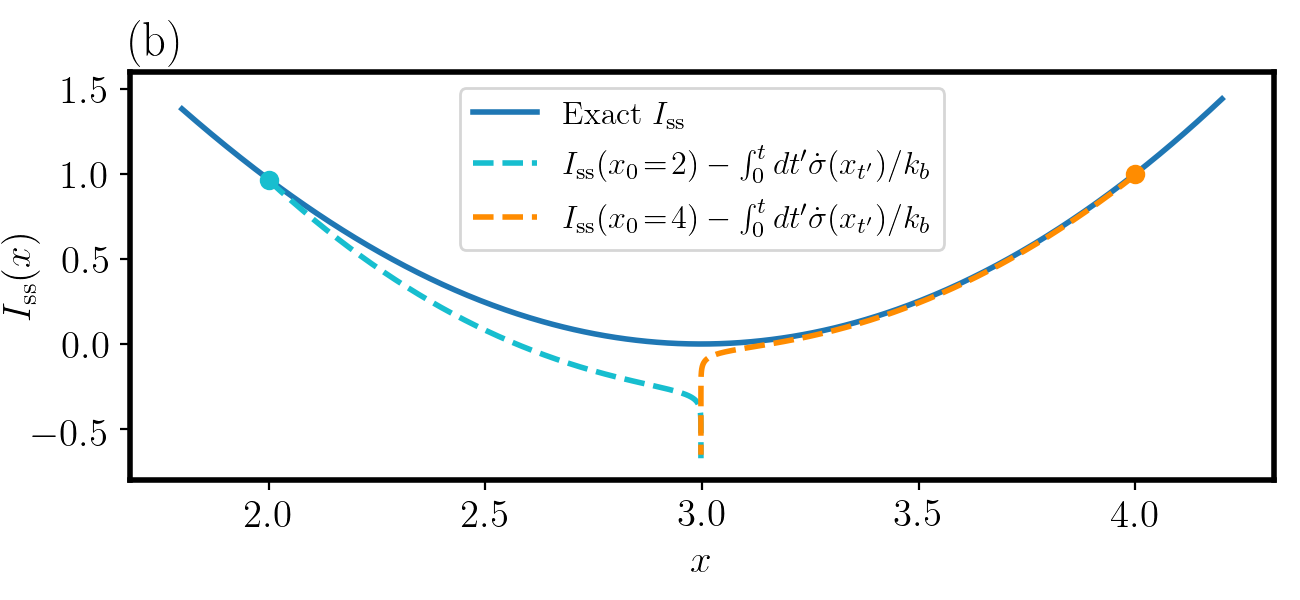

In [13]:
#Direct input 
plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
#Options
params = {'text.usetex' : True,
          'font.size' : 14,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params)

f, ax = plt.subplots(1, 1, sharex=False, figsize=(6.5,3), dpi=200)
plt.gcf().subplots_adjust(right=.98,left=0.10,hspace=.18, bottom=.2)


vd=3

# for a in ax:
#     plt.setp(a.spines.values(), linewidth=2)

plt.setp(ax.spines.values(), linewidth=2)

# X = np.linspace(-6,6,500)
# EG = np.array([exact_g(v, vd, n=1) for v in X])
# AG1 = np.array([approx_g_1st(v, vd, n) for v in X])

# EG = EG-np.min(EG)    
# AG1 = AG1-np.min(AG1)    

# ax[0].plot(X, EG)
# ax[0].plot(X, AG1, '--', linewidth=1)
    
    
X = np.linspace(1.8,4.2,500)
EG = np.array([exact_g(v, vd, n=1) for v in X])
EG = EG-np.min(EG)
# AG1 = np.array([approx_g_1st(v, vd, n) for v in X])

c1 = ax.plot(X, EG, label=r"Exact $I_\mathrm{ss}$", linewidth=2)
# ax.plot(X, AG1-np.min(AG1))


V = np.load('traj_V1.npy')[:-5500]
Q = np.load('traj_Q1.npy')[:-5500]
ax.plot([v[0] for v in V], EG[np.argmin(np.abs(X-V[0][0]))]-(np.cumsum(Q)*1e-5), '--', color='C9', label=r"$I_\mathrm{ss}(x_0 \! = \! 2) - \int_0^t dt' \dot \sigma(x_{t'})/k_b$", linewidth=2)
ax.plot(V[0][0],[EG[np.argmin(np.abs(X-V[0][0]))]],'o',color='C9',label=None)


V = np.load('traj_V2.npy')[:-45000]
Q = np.load('traj_Q2.npy')[:-45000]
ax.plot([v[0] for v in V], EG[np.argmin(np.abs(X-V[0][0]))]-(np.cumsum(Q)*1e-6), '--', color='darkorange', label=r"$I_\mathrm{ss}(x_0 \! = \! 4) - \int_0^t dt' \dot \sigma(x_{t'})/k_b$", linewidth=2)
ax.plot(V[0][0],[EG[np.argmin(np.abs(X-V[0][0]))]],'o',color='darkorange')
    
    
#ax[0].set_xlabel(r'$x/V_T$')    
ax.set_xlabel(r'$x$')    

#ax[0].set_ylabel(r'$I_\mathrm{ss}(x)/V_T$')    
ax.set_ylabel(r'$I_\mathrm{ss}(x)$', labelpad=-3)    


#ax[0].legend([r'Exact $I_\mathrm{ss}$', "Linear response"], fontsize='x-small', loc='upper center')
ax.legend(fontsize='small', loc='upper center')



#ax[0].set_yticks([0,2,4,6,8])
ax.set_ylim(-.8,1.6)

plt.title('(b)', loc='left')
plt.savefig('rate_func_2.pdf')

<IPython.core.display.Javascript object>


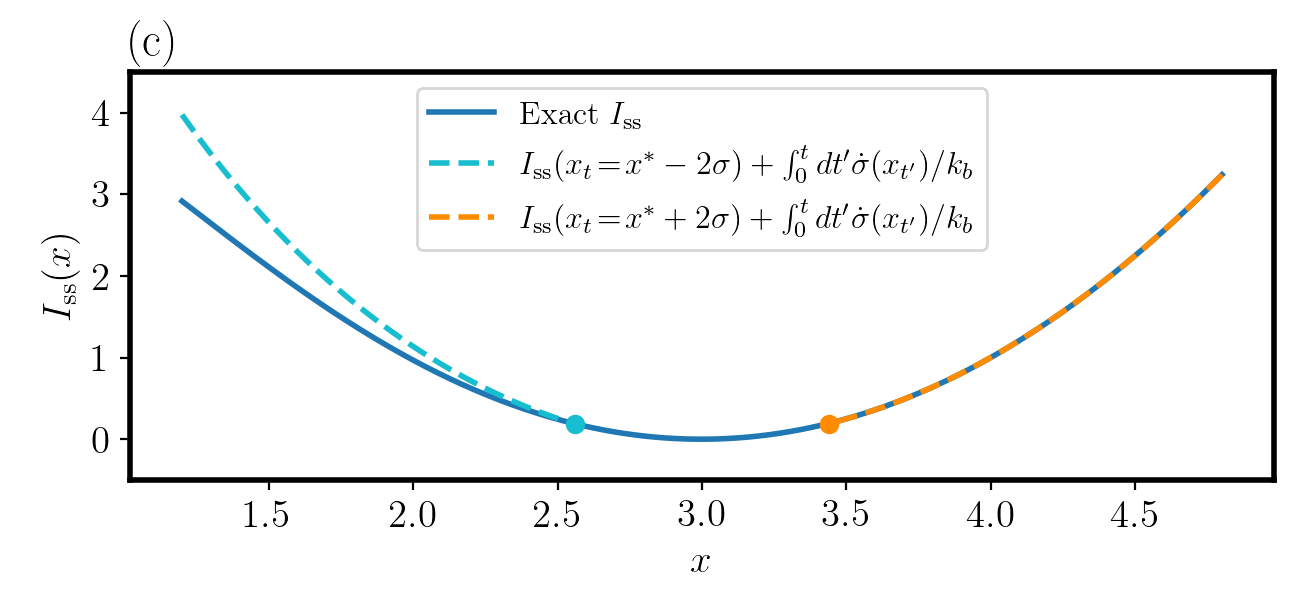

In [14]:
#Direct input 
plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
#Options
params = {'text.usetex' : True,
          'font.size' : 14,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params)

f, ax = plt.subplots(1, 1, sharex=False, figsize=(6.5,3), dpi=200)
plt.gcf().subplots_adjust(right=.98,left=0.10,hspace=.18, bottom=.2)

vd=3

# for a in ax:
#     plt.setp(a.spines.values(), linewidth=2)

plt.setp(ax.spines.values(), linewidth=2)

    
X = np.linspace(1.2,4.8,500)
EG = np.array([exact_g(v, vd, n=1) for v in X])
EG = EG-np.min(EG)
# AG1 = np.array([approx_g_1st(v, vd, n) for v in X])

ax.plot(X, EG, label=r"Exact $I_\mathrm{ss}$", linewidth=2)


V = np.load('traj_V3.npy')
ind = np.argmin(np.abs(V[:,0]-(3-2*0.22)))
V = V[:ind]
Q = np.load('traj_Q3.npy')[:ind]
ax.plot([v[0] for v in V], EG[np.argmin(np.abs(X-V[-1][0]))]+(np.sum(Q)*1e-6-np.cumsum(Q)*1e-6), '--', color='C9', label=r"$I_\mathrm{ss}(x_t \! = \! x^*-2\sigma) + \int_0^t dt' \dot \sigma(x_{t'})/k_b$", linewidth=2)
ax.plot([V[-1][0]],[EG[np.argmin(np.abs(X-V[-1][0]))]],'o',color='C9',label=None)


V = np.load('traj_V4.npy')
ind = np.argmin(np.abs(V[:,0]-(3+2*0.22)))
V = V[:ind]
Q = np.load('traj_Q4.npy')[:ind]
ax.plot([v[0] for v in V], EG[np.argmin(np.abs(X-V[-1][0]))]+(np.sum(Q)*1e-7-np.cumsum(Q)*1e-7), '--', color='darkorange', label=r"$I_\mathrm{ss}(x_t \! = \! x^*+2\sigma) + \int_0^t dt' \dot \sigma(x_{t'})/k_b$", linewidth=2)
ax.plot([V[-1][0]],[EG[np.argmin(np.abs(X-V[-1][0]))]],'o',color='darkorange',label=None)

# asd = np.linspace(1,5,500)
# ax.plot(asd, (asd-3)**2)
    
#ax[0].set_xlabel(r'$x/V_T$')    
ax.set_xlabel(r'$x$')    

#ax[0].set_ylabel(r'$I_\mathrm{ss}(x)/V_T$')    
ax.set_ylabel(r'$I_\mathrm{ss}(x)$')    


#ax[0].legend([r'Exact $I_\mathrm{ss}$', "Linear response"], fontsize='x-small', loc='upper center')
ax.legend(fontsize='small', loc='upper center')


#ax[0].set_yticks([0,2,4,6,8])
ax.set_ylim(-.5,4.5)


plt.title('(c)', loc='left')
plt.savefig('rate_func_3.pdf')

<IPython.core.display.Javascript object>


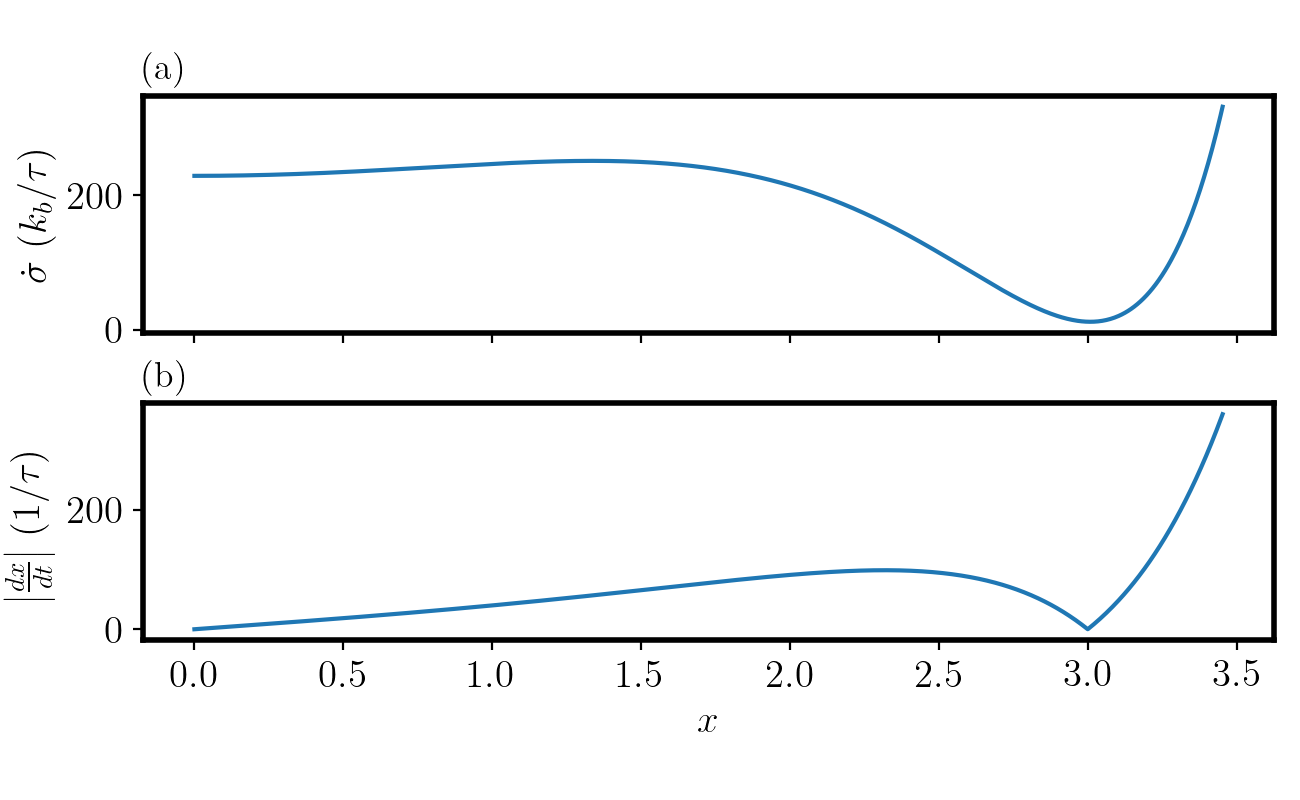

In [15]:
#Direct input 
plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
#Options
params = {'text.usetex' : True,
          'font.size' : 14,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params)

f, ax = plt.subplots(2, 1, sharex=True, figsize=(6.5,4), dpi=200)
plt.gcf().subplots_adjust(right=.98,left=0.11,hspace=.3, bottom=.2)

for a in ax:
    plt.setp(a.spines.values(), linewidth=2)



V = np.linspace(0,3.45,1000)

Q = np.array([heat_rate([v, -v], 3) for v in V])
W = np.array([work_rate([v, -v], 3) for v in V])
D = np.array([drift(0,[v, -v], 3)[0] for v in V])

ax[0].plot(V,Q)
#ax[0].plot(V,W)
ax[1].plot(V,np.abs(D))

#ax[0].set_yscale('log')
#ax[1].set_yscale('log')

ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$\left\vert \frac{dx}{dt} \right\vert$  ($1/\tau$)')
ax[0].set_ylabel(r'$\dot \sigma$  ($k_b/\tau$)')

ax[0].set_title('(a)', loc='left', fontsize=13)
ax[1].set_title('(b)', loc='left', fontsize=13)

plt.savefig('heat_velocity.pdf')

<IPython.core.display.Javascript object>


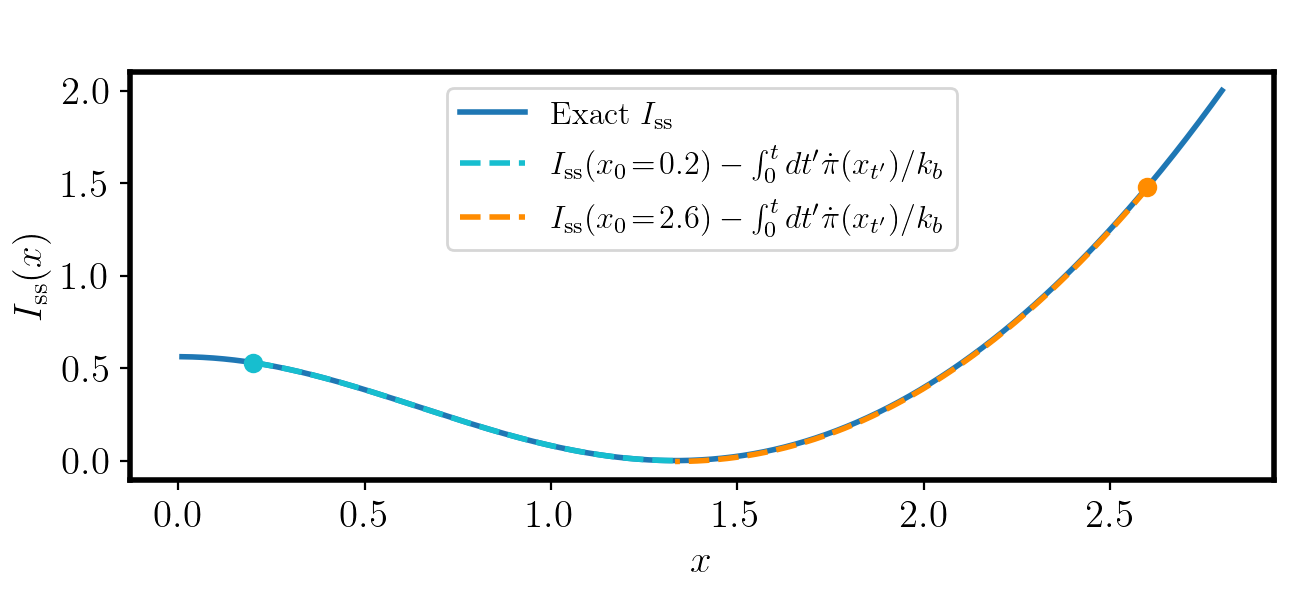

[-0.2  0.2]
[-2.6  2.6]


In [16]:
#Direct input 
plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
#Options
params = {'text.usetex' : True,
          'font.size' : 14,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params)

f, ax = plt.subplots(1, 1, sharex=False, figsize=(6.5,3), dpi=200)
plt.gcf().subplots_adjust(right=.98,left=0.10,hspace=.18, bottom=.2)


vd=1.4

# for a in ax:
#     plt.setp(a.spines.values(), linewidth=2)

plt.setp(ax.spines.values(), linewidth=2)

# X = np.linspace(-6,6,500)
# EG = np.array([exact_g(v, vd, n=1) for v in X])
# AG1 = np.array([approx_g_1st(v, vd, n) for v in X])

# EG = EG-np.min(EG)    
# AG1 = AG1-np.min(AG1)    

# ax[0].plot(X, EG)
# ax[0].plot(X, AG1, '--', linewidth=1)
    
    
X = np.linspace(.01,2.8,500)
EG = np.array([exact_g(v, vd, n=1) for v in X])
EG = EG-np.min(EG)
# AG1 = np.array([approx_g_1st(v, vd, n) for v in X])

c1 = ax.plot(X, EG, label=r"Exact $I_\mathrm{ss}$", linewidth=2)
# ax.plot(X, AG1-np.min(AG1))


T = np.load('traj_ex1_T.npy')[:-5500]
V = np.load('traj_ex1_V.npy')[:-5500]
print(V[0])
Q = np.array([cg_heat_rate(v, vd) for v in V])
ax.plot([v[1] for v in V], EG[np.argmin(np.abs(X-V[0][1]))]-(np.cumsum(Q)*(T[1]-T[0])), '--', color='C9', label=r"$I_\mathrm{ss}(x_0 \! = \! 0.2) - \int_0^t dt' \dot \pi(x_{t'})/k_b$", linewidth=2)
ax.plot(V[0][1],[EG[np.argmin(np.abs(X-V[0][1]))]],'o',color='C9',label=None)


T = np.load('traj_ex2_T.npy')[:-5500]
V = np.load('traj_ex2_V.npy')[:-5500]
print(V[0])
Q = np.array([cg_heat_rate(v, vd) for v in V])
ax.plot([v[1] for v in V], EG[np.argmin(np.abs(X-V[0][1]))]-(np.cumsum(Q)*(T[1]-T[0])), '--', color='darkorange', label=r"$I_\mathrm{ss}(x_0 \! = \! 2.6) - \int_0^t dt' \dot \pi(x_{t'})/k_b$", linewidth=2)
ax.plot(V[0][1],[EG[np.argmin(np.abs(X-V[0][1]))]],'o',color='darkorange')
    
    
#ax[0].set_xlabel(r'$x/V_T$')    
ax.set_xlabel(r'$x$')    

#ax[0].set_ylabel(r'$I_\mathrm{ss}(x)/V_T$')    
ax.set_ylabel(r'$I_\mathrm{ss}(x)$')    


#ax[0].legend([r'Exact $I_\mathrm{ss}$', "Linear response"], fontsize='x-small', loc='upper center')
ax.legend(fontsize='small', loc='upper center')



#ax[0].set_yticks([0,2,4,6,8])
#ax.set_ylim(-.8,1.6)

plt.savefig('cg_bound.pdf')